In [ ]:
#pip install opencv-python-headless

In [1]:
#import cv2
import numpy as np
import random
import math
import sys
import os
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from shutil import copy
import time

process the dataset

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

BATCH_SIZE = 1
path1 = "./Dataset"
classes = ['0', '1', '2', '3', '4', '5','6','7','8','9']
n_classes = len(classes)

def data_loader(root=path1):
        # Define image transforms
    train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # reverse 50% of images
            #transforms.RandomRotation(10),      # up to 10 degrees of random rotation
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])   
                                                      # In FINN, we prefer to work with bipolar {-1, +1} 
                                                      # instead of binary {0, 1} values.

    test_transform = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])
    train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
    test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, test_loader

train_loader, test_loader = data_loader(root=path1)

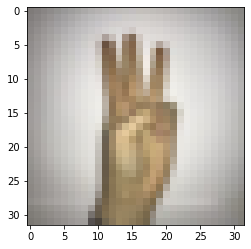

tensor([[[[127., 131., 137.,  ..., 146., 140., 136.],
          [130., 136., 143.,  ..., 153., 146., 139.],
          [135., 141., 149.,  ..., 159., 152., 143.],
          ...,
          [132., 138., 145.,  ..., 148., 142., 134.],
          [127., 132., 138.,  ..., 144., 137., 130.],
          [123., 128., 132.,  ..., 138., 133., 128.]],

         [[123., 127., 133.,  ..., 145., 139., 135.],
          [126., 132., 139.,  ..., 152., 145., 138.],
          [131., 137., 145.,  ..., 157., 151., 142.],
          ...,
          [129., 135., 142.,  ..., 146., 139., 131.],
          [124., 129., 135.,  ..., 142., 134., 127.],
          [120., 125., 129.,  ..., 136., 131., 125.]],

         [[121., 126., 132.,  ..., 140., 135., 132.],
          [125., 131., 138.,  ..., 150., 142., 134.],
          [130., 136., 144.,  ..., 159., 150., 138.],
          ...,
          [124., 130., 137.,  ..., 141., 132., 123.],
          [119., 124., 130.,  ..., 139., 129., 120.],
          [115., 120., 125.,  ...

In [110]:
n = 20
cnt = 0

for m, (X_train, y_train) in enumerate(train_loader): 
    #if m == n:
        #print(X_train)
        #print(y_train)
    if cnt>=1: 
        break    
    img = X_train[0]   
    img = img.numpy()   
    img = np.transpose(img, (1,2,0))
    input_tensor = X_train
    label = y_train

    plt.imshow(img)
    plt.show()
    print(X_train*255)
    print(y_train)
    print(X_train.shape)
    print(y_train.shape)
    cnt += 1
 

creat test data if needed

In [115]:
'''
output_txt = input_tensor*255
output_txt = output_txt.squeeze()

output_txt_R = output_txt[0:1]
output_txt_R = (np.array((output_txt_R.squeeze()).view(32*32,-1))).astype(int)
np.savetxt('./test_data_32/test_9_R.txt',output_txt_R, fmt="%x")

output_txt_G = output_txt[1:2]
output_txt_G = (np.array((output_txt_G.squeeze()).view(32*32,-1))).astype(int)
np.savetxt('./test_data_32/test_9_G.txt',output_txt_G, fmt="%x")

output_txt_B = output_txt[2:3]
output_txt_B = (np.array((output_txt_B.squeeze()).view(32*32,-1))).astype(int)
np.savetxt('./test_data_32/test_9_B.txt',output_txt_B, fmt="%x")
'''

In [6]:
import brevitas.onnx as bo
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU
from brevitas.core.quant import QuantType
import torch.nn as nn
from torch import optim

describe the model

In [7]:
# LeNet   

class Gesture_Recognizer(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(Gesture_Recognizer,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=6,kernel_size=5,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=6,out_channels=16,kernel_size=5,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=16,out_channels=120,kernel_size=5,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        
        
        self.drop1 = QuantDropout(p=0.5)
        
        self.fc1 = QuantLinear(1*1*120,64,bias=False,weight_bit_width=weight_bit_width)
        self.relu6 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(64,num_classes,bias=False,weight_bit_width=weight_bit_width)
        self.relu7 = QuantReLU(bit_width=act_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.cnn1(x)))
        x = self.maxpool2(self.relu2(self.cnn2(x)))
        x = self.relu3(self.cnn3(x))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu6(self.fc1(x))
        x = self.relu7(self.fc2(x))
        
        return x

load the parameters

In [ ]:
input_size = 3 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 4
act_bit_width = 4

original_model = Gesture_Recognizer(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)
state_dict = torch.load('./test/LeNet_model_parameter_W4A4.pth')
original_model.load_state_dict(state_dict)
original_model.eval()

In [111]:
print(input_tensor.shape)
print("input:",input_tensor)
print("Label_true:",label)

torch.Size([1, 3, 32, 32])
input: tensor([[[[0.4980, 0.5137, 0.5373,  ..., 0.5725, 0.5490, 0.5333],
          [0.5098, 0.5333, 0.5608,  ..., 0.6000, 0.5725, 0.5451],
          [0.5294, 0.5529, 0.5843,  ..., 0.6235, 0.5961, 0.5608],
          ...,
          [0.5176, 0.5412, 0.5686,  ..., 0.5804, 0.5569, 0.5255],
          [0.4980, 0.5176, 0.5412,  ..., 0.5647, 0.5373, 0.5098],
          [0.4824, 0.5020, 0.5176,  ..., 0.5412, 0.5216, 0.5020]],

         [[0.4824, 0.4980, 0.5216,  ..., 0.5686, 0.5451, 0.5294],
          [0.4941, 0.5176, 0.5451,  ..., 0.5961, 0.5686, 0.5412],
          [0.5137, 0.5373, 0.5686,  ..., 0.6157, 0.5922, 0.5569],
          ...,
          [0.5059, 0.5294, 0.5569,  ..., 0.5725, 0.5451, 0.5137],
          [0.4863, 0.5059, 0.5294,  ..., 0.5569, 0.5255, 0.4980],
          [0.4706, 0.4902, 0.5059,  ..., 0.5333, 0.5137, 0.4902]],

         [[0.4745, 0.4941, 0.5176,  ..., 0.5490, 0.5294, 0.5176],
          [0.4902, 0.5137, 0.5412,  ..., 0.5882, 0.5569, 0.5255],
        

check if predict correctly

In [112]:
output_golden = original_model.forward(input_tensor)
print("output_golden:",output_golden)

output_golden_label = output_golden
output_golden_label = torch.max(output_golden_label,1)[1]
print("Label_pred:",output_golden_label)

output_golden: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 4.4067, 0.0000, 6.6100, 0.0000, 0.0000,
         0.0000]], grad_fn=<MulBackward0>)
Label_pred: tensor([6])


In [15]:
import netron
from IPython.display import IFrame

def showInNetron(model_filename):
    netron.start(model_filename, address=("0.0.0.0",8081))
    return IFrame(src="http://0.0.0.0:8081/",width="100%",height=400)

## Simulation using Python

import ONNX model from streamline step, and check if predict correctly

In [113]:
import numpy as np
from finn.core.modelwrapper import ModelWrapper
import onnx.numpy_helper as nph

input_test1 = input_tensor*255

input_test1 = (input_test1.numpy()).astype(np.float32)#.tolist()
input_dict = {"global_in": input_test1}
print("input:",input_test1)
print("Label_true:",label)

model_for_sim = ModelWrapper("./test/output_ipstitch/intermediate_models/2_step_streamline.onnx")

input: [[[[127. 131. 137. ... 146. 140. 136.]
   [130. 136. 143. ... 153. 146. 139.]
   [135. 141. 149. ... 159. 152. 143.]
   ...
   [132. 138. 145. ... 148. 142. 134.]
   [127. 132. 138. ... 144. 137. 130.]
   [123. 128. 132. ... 138. 133. 128.]]

  [[123. 127. 133. ... 145. 139. 135.]
   [126. 132. 139. ... 152. 145. 138.]
   [131. 137. 145. ... 157. 151. 142.]
   ...
   [129. 135. 142. ... 146. 139. 131.]
   [124. 129. 135. ... 142. 134. 127.]
   [120. 125. 129. ... 136. 131. 125.]]

  [[121. 126. 132. ... 140. 135. 132.]
   [125. 131. 138. ... 150. 142. 134.]
   [130. 136. 144. ... 159. 150. 138.]
   ...
   [124. 130. 137. ... 141. 132. 123.]
   [119. 124. 130. ... 139. 129. 120.]
   [115. 120. 125. ... 135. 129. 119.]]]]
Label_true: tensor([6])


In [114]:
import finn.core.onnx_exec as oxe
output_dict = oxe.execute_onnx(model_for_sim, input_dict)
output_pysim = output_dict[list(output_dict.keys())[0]]
print("Results for Simulation: Label_pred",output_pysim)

Results for Simulation: Label_pred [[6]]
